# Home work 1: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending two files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

You can test your Modules.ipynb by sending it to telegram bot @rdl_hw3_bot. Please do not use your hacking skills on the bot since this message is the only security measure.

In [16]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run modules.ipynb

Basic optimization method is implemeted for you, but you have to implement Nesterov accelerated gradient yourself, and Adam optimization method is an optional task.

In [33]:
def sgd_momentum(x, dx, config, state):
    """
        Example implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1
            
def nesterov(x, dx, config, state):
    """
    Nesterov accelerated gradient with momentum
    """
    #implement nesterov accelerated gradient
    #difference between sgd and nesterov is explained in:
    #http://caffe.berkeleyvision.org/tutorial/solver.html
    #http://lasagne.readthedocs.io/en/latest/modules/updates.html
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= config['learning_rate'] * cur_dx + config['momentum'] * cur_old_grad
            i += 1

def adam(x, dx, config, state):
    """
    Adam optimization method.
    Reference paper:
    Kingma, Diederik, and Jimmy Ba (2014): Adam: A Method for Stochastic Optimization.
    https://arxiv.org/abs/1412.6980
    """
    #this one is optional
    pass

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

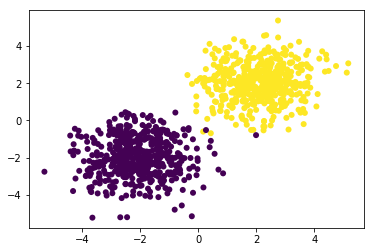

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(SoftMax())

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(BatchMeanSubtraction(0.8))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 4
BatchMeanNormalization
ReLU
Linear 4 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

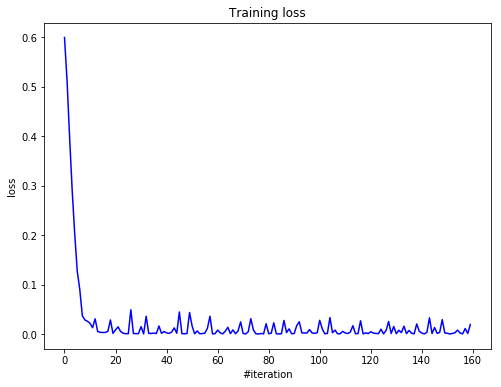

Current loss: 0.019252


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [9]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X_train = data['X_train']
        y_train = data['y_train']
        X_test = data['X_test']
        y_test = data['y_test']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [10]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
enc.fit(y_train.reshape((-1, 1)))
y_train = enc.transform(y_train.reshape((-1, 1)))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=.1)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
It would be better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- **Compare** available optimization methods for the best architecture you have found previously.
- Hint: logloss for MNIST should be around 0.5. 

In [21]:
n = X_train.shape[1]

def model(nonlinearity, batchnorm=True):
    net = Sequential()
    net.add(Linear(n, 200))
    if batchnorm:
        net.add(BatchMeanSubtraction(0.8))
    net.add(nonlinearity)
    net.add(Linear(200, 10))
    net.add(SoftMax())
    return net

nonlinearities = [ReLU(), SoftPlus(), LeakyReLU(0.1), ELU()]

nets = {}
losses = {}
validation_losses = {}
for nonlinearity in nonlinearities:
    name = str(nonlinearity)
    nets[name] = model(nonlinearity, batchnorm=False)
    nets[name + ' with BatchMeanSubtraction'] = model(nonlinearity, batchnorm=True)  

In [22]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [23]:
criterion = ClassNLLCriterion()

for name, net in nets.iteritems():
    
    optimizer_state = {}
    loss_history = []
    vloss_history = []
    
    for i in xrange(n_epoch):
        net.train()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()

            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
            
            loss_history.append(loss)
            
        net.evaluate()
        predictions = net.forward(X_validation)
        loss = criterion.forward(predictions, y_validation)    
        vloss_history.append(loss)
        
    losses[name] = loss_history
    validation_losses[name] = vloss_history

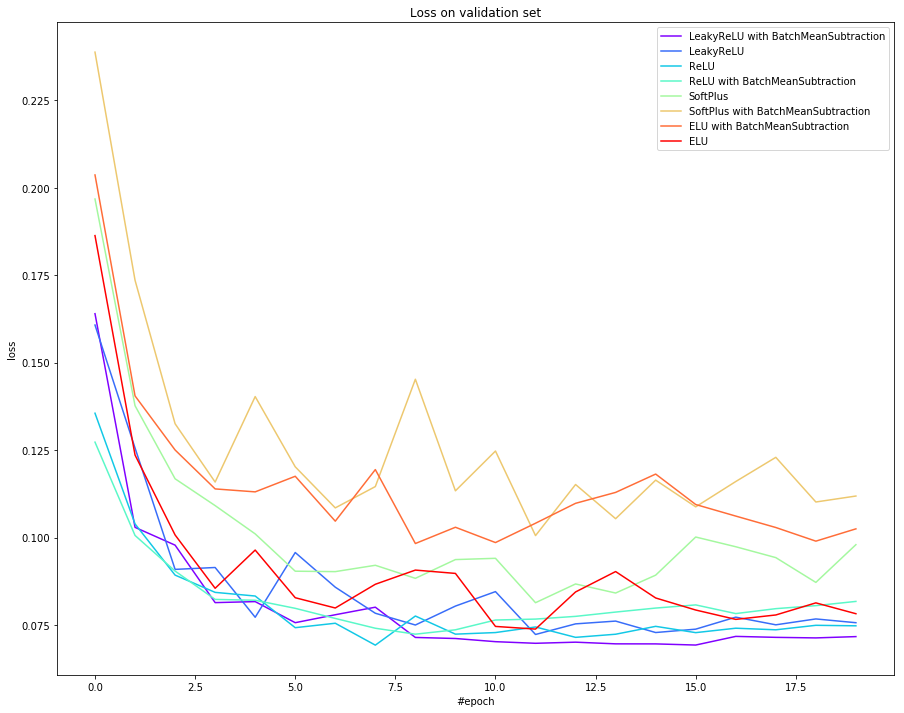

In [24]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 8)))

plt.figure(figsize=(15, 12))
        
plt.title("Loss on validation set")
plt.xlabel("#epoch")
plt.ylabel("loss")
for name, loss in validation_losses.iteritems():
    c=next(color)
    plt.plot(loss, label=name, c=c)

    
plt.legend(loc='best')
plt.show()

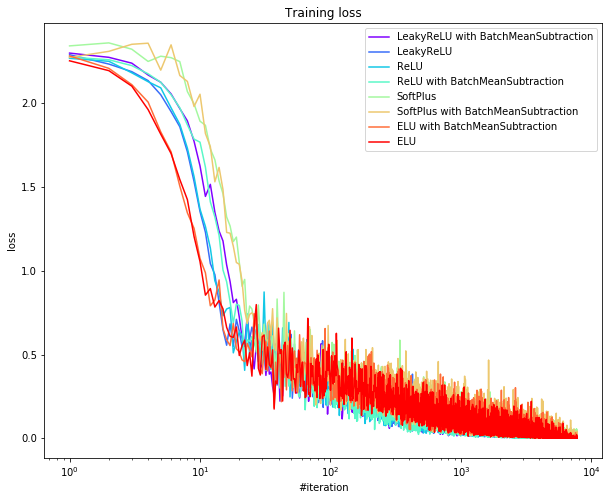

In [25]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 8)))

plt.figure(figsize=(10, 8))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
for name, loss in losses.iteritems():
    c = next(color)
    plt.semilogx(loss, label=name, c=c)
    
plt.legend(loc='best')
plt.show()

In [26]:
def get_batch((X, y), batch_size):
    ind = random.sample(range(X.shape[0]), batch_size)
    return X[ind], y[ind]

In [27]:
import random

forward_time = {}
backward_time = {}

random.seed(1)
x_batch, y_batch = get_batch((X_train, y_train), batch_size)

for name, net in nets.iteritems():
    
    net.zeroGradParameters()
    
    res = %timeit -o net.forward(x_batch)
    forward_time[name] = res.best
    predictions = net.forward(x_batch)
    dp = criterion.backward(predictions, y_batch)
    res = %timeit -o net.backward(x_batch, dp)
    backward_time[name] = res.best

The slowest run took 6.81 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 720 µs per loop
1000 loops, best of 3: 959 µs per loop
1000 loops, best of 3: 642 µs per loop
1000 loops, best of 3: 969 µs per loop
The slowest run took 6.61 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 665 µs per loop
1000 loops, best of 3: 948 µs per loop
The slowest run took 5.00 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 765 µs per loop
1000 loops, best of 3: 1.02 ms per loop
1000 loops, best of 3: 1.57 ms per loop
1000 loops, best of 3: 1.25 ms per loop
100 loops, best of 3: 2.08 ms per loop
1000 loops, best of 3: 1.26 ms per loop
The slowest run took 4.95 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.15 ms per loop
1000 loops, best

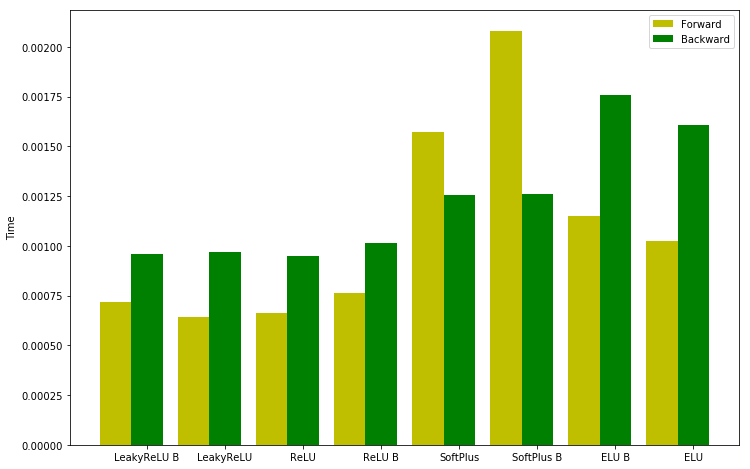

In [28]:
ftime = []
btime = []
names = []
for name, time in forward_time.iteritems():
    ftime.append(time)
    btime.append(backward_time[name])
    if len(name) > 10:
        name = name[:-25] + 'B'
    names.append(name)

ind = np.arange(8)  
width = 0.4       

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)

rects1 = ax.bar(ind, ftime, width, color='y')
rects2 = ax.bar(ind + width, btime, width, color='g')

ax.set_ylabel('Time')
ax.set_xticks(ind + width)
ax.set_xticklabels(names)

ax.legend((rects1[0], rects2[0]), ('Forward', 'Backward'), loc='best')

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

LeakyReLU with BatchMeanSubtraction was better then other on validation set, and it works fast. However, ELU was better on training set. 

In [34]:
lrelunets = {'sgd_momentum': model(LeakyReLU(.1)), 'nesterov': model(LeakyReLU(.1))}

criterion = ClassNLLCriterion()

losses = {}
validation_losses = {}

for name, net in lrelunets.iteritems():
    
    optimizer_state = {}
    loss_history = []
    vloss_history = []
    
    for i in xrange(n_epoch):
        net.train()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()

            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            if name == 'sgd_momentum':
                sgd_momentum(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state) 
            else:
                nesterov(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state)
                
            
            loss_history.append(loss)
            
        net.evaluate()
        predictions = net.forward(X_validation)
        loss = criterion.forward(predictions, y_validation)    
        vloss_history.append(loss)
        
    losses[name] = loss_history
    validation_losses[name] = vloss_history

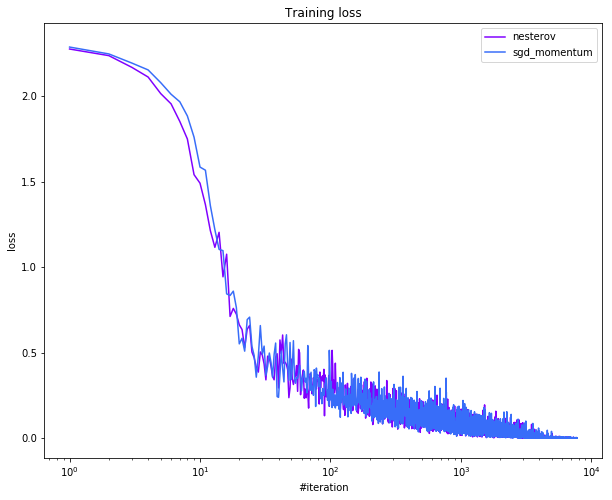

In [35]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 8)))

plt.figure(figsize=(10, 8))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
for name, loss in losses.iteritems():
    c = next(color)
    plt.semilogx(loss, label=name, c=c)
    
plt.legend(loc='best')
plt.show()

What optimization method was the best for you?

Nesterov was better then SGD with momentum according to the graph.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting. You can use **data augmentation** such as rotations, translations to boost your score, or play with **learning rate decay** for faster convergence. Use your knowledge and imagination to train a model.

In [36]:
X_train = np.vstack((X_train, X_validation))
y_train = np.vstack((y_train, y_validation))

In [66]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 40
batch_size = 128

#Our network
net = Sequential()
net.add(Linear(X_train.shape[1], 200))
net.add(BatchMeanSubtraction(.85))
net.add(LeakyReLU(0.1))
net.add(Dropout(.8))
net.add(Linear(200, 10))
net.add(SoftMax())
print net

Linear 784 -> 200
BatchMeanNormalization
LeakyReLU
Dropout
Linear 200 -> 10
SoftMax



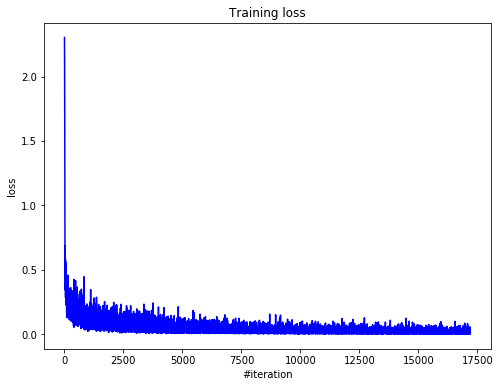

In [68]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train) , batch_size):
        net.zeroGradParameters()
    
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        nesterov(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)  
        
        loss_history.append(loss)
        
    if (i + 1) % 5 == 0:
        optimizer_config['learning_rate'] /= 1.2

# Visualize
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

In [69]:
net.evaluate()
predictions = net.forward(X_test).argmax(axis=1)
print (predictions == y_test).mean()

0.9822


Print here your accuracy. It should be > 90%.

In [ ]:
# Your answer goes here. ################################################